# Notebook to assess accuracy of an offline, volume-integrated heat budget for TXLA model output. 
## Dropping the overbar and primes used in the standard Reynolds averaged tracer equations, the potential temperature equation $T$ may be written as 
### $\frac{\partial T}{\partial t}+ \textbf{u} \cdot \nabla T =\nabla_H \cdot (\kappa_H \nabla_H T)+  \frac{\partial}{\partial z} \left(\kappa_V {\frac{\partial T}{\partial z}} \right),$
where 
>- $T$ is the temperature, 
>- $\mathbf{u}$ is the 3D velocity vector, 
>- $\kappa_H$ is the lateral eddy diffusivity,
>- $\kappa_V$ is the vertical eddy diffusivity. 

Locally, each collective term  has units of degrees C per second. The vertical boundary conditions are written as 
<br>
### $\kappa_V  \left(\frac{\partial T}{\partial z}\right)=\frac{Q_{net}}{\rho_0 C_p}$ @ $z=\eta$ ,
### $\kappa_V  \left(\frac{\partial T}{\partial z}\right)=0$ @ $z=-h$,
where 
>- $C_p$ is the specific heat of seawater [J/kg/deg C]. 
>    > - $C_p=3985$ for COAWST ver. 3.8 COAWST/ROMS/Modules/mod_scalars.F. See https://github.com/DOI-USGS/COAWST/blob/892f4bdd8fede921381096656393084e1eead448/ROMS/Modules/mod_scalars.F#L2
>- $Q_{net}=Q_{sho}+Q_{lon}+Q_{sen}+Q_{lat}$ is the surface net heat flux [W/m$^2$] with four components:
>   > - $Q_{sho}$ is the shortwave flux [W/m$^2$]
>   > - $Q_{lon}$ is the longwave flux [W/m$^2$]
>   > - $Q_{sen}=\rho_{a}c_{pa} C_s U(T_{ocn}-T_{air})$ is the sensible heat flux [W/m$^2$] with air density $\rho_a$, $c_{pa}$ is the specific heat capacity of air, $C_s$ is a turbulent exchange coefficient for sensible heat, and $T_{ocn}$ and $T_{air}$ are the ocean and water temperatures, respectively.
>   > - $Q_{lat}=\rho_{a}L_{v} C_l U(q_{ocn}-q_{air})$ is the latent heat flux [W/m$^2$] with latent heat of vaporization $L_v$, turbulent exchange coefficient for latent heat $C_l$, and $q_*$ refers to the humidity difference between the ocean and atmosphere. 
>- $\eta$ is the free surface
>- $h$ is the depth of the seafloor 

After volume-integrating over a control volume extending from the ocean bottom to the sea surface, we have 
### $\iiint \partial_t T \, dV + \iint (\mathbf{u}T) \cdot \hat{n} \, dA = \iint \frac{Q_{net}}{\rho_0 C_p} \, dA$.

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-92.5)

In [2]:
tslice = slice('2022-07-01','2022-07-05')
etaslice = slice(260,473) # Different indices than 2010 notebook because grid changed! 
xislice = slice(115,219)

path = glob.glob('/d1/shared/TXLA_ROMS/nesting/2022/nest/ocean_his_child*.nc')
ds = xroms.open_mfnetcdf(path, chunks = {'ocean_time':1})
ds, grid = xroms.roms_dataset(ds, Vtransform = 2)
ds = ds.sel(ocean_time=tslice)

In [3]:
def states_coastline(ax, resolution='10m', linewidth=0.5, color='black', states=True):
	ax.coastlines(resolution=resolution, color=color, linewidth=linewidth)

	states_provinces = cfeature.NaturalEarthFeature(
		    category='cultural',
		    name='admin_1_states_provinces_lakes',
		    scale=resolution,
		    facecolor='none')
	if states:	    
		ax.add_feature(states_provinces, edgecolor=color, linewidth=linewidth)
        
# Box for the location of the cruise
lon = np.array([-92.9,-92.6])
lat = np.array([28.8,29.2])
box = ((lon[0] < ds.lon_rho) & (ds.lon_rho < lon[1]) & (lat[0] < ds.lat_rho) & (ds.lat_rho < lat[1])).compute()

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/d2/home/dylan/.conda/envs/copano/lib/py

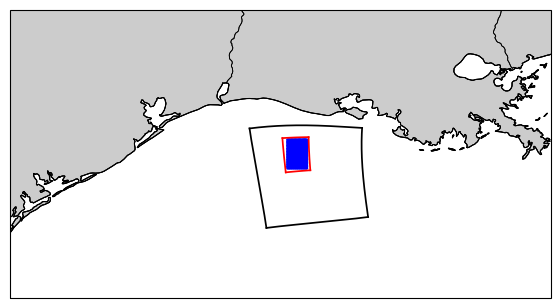

In [4]:
fig, ax = plt.subplots(1, figsize = (1.83*2*1.5,1.52*1.3*1.5), subplot_kw={'projection': crs}, constrained_layout = True)

ax.plot(ds.lon_rho[0,:], ds.lat_rho[0,:], 'k', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(ds.lon_rho[:,0], ds.lat_rho[:,0], 'k', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds.lon_rho[:,-1], ds.lat_rho[:,-1], 'k', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds.lon_rho[-1,:], ds.lat_rho[-1,:], 'k', lw=1.25,transform = cartopy.crs.PlateCarree(),)

ax.plot(ds.lon_rho.where(box), ds.lat_rho.where(box), 'b', lw=1.25,transform = cartopy.crs.PlateCarree(),)

ax.plot(ds.isel(eta_rho=etaslice, xi_rho=xislice).lon_rho[0,:], 
        ds.isel(eta_rho=etaslice, xi_rho=xislice).lat_rho[0,:], 
        'r', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(ds.isel(eta_rho=etaslice, xi_rho=xislice).lon_rho[:,0], 
        ds.isel(eta_rho=etaslice, xi_rho=xislice).lat_rho[:,0], 
        'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds.isel(eta_rho=etaslice, xi_rho=xislice).lon_rho[:,-1],
        ds.isel(eta_rho=etaslice, xi_rho=xislice).lat_rho[:,-1],
        'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds.isel(eta_rho=etaslice, xi_rho=xislice).lon_rho[-1,:],
        ds.isel(eta_rho=etaslice, xi_rho=xislice).lat_rho[-1,:],
        'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.set_extent([-97, -89, 27, 31], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8', linewidth = 0.8)
ax.coastlines(resolution='10m', linewidth = 0.8)  
states_coastline(ax, resolution='10m', linewidth=0.6, color='black')
ax.set_aspect('auto')

## Time rate of change 

In [5]:
def time_tendency(ds, etaslice, xislice, tslice):
    #Tendency term - centered finite difference  
    temp = ds.temp.isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time=tslice).values
    delta = (ds.dV).isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time=tslice).values

    tempv = temp*delta
    dtempvdt = (((tempv)[2:] - (tempv)[:-2])/(2*3600)) #2*dt,dt = 3600 s/hr
    dtempvdt_v =  dtempvdt/(delta[1:-1])
    dTdt = (dtempvdt_v*delta[1:-1]).sum(axis = (1,2,3))

    return dTdt

dTdt = time_tendency(ds, etaslice, xislice, tslice)

# Advection through the lateral boundaries 

In [6]:
def advection(grid, ds, tslice, etaslice, xislice):
    # Advection term 
    dydzt = grid.interp((ds.dy*ds.dz*ds.temp), 'X')
    dxdzt = grid.interp((ds.dx*ds.dz*ds.temp), 'Y')

    utflux = (dydzt*ds.u).sel(ocean_time=tslice)
    vtflux = (dxdzt*ds.v).sel(ocean_time=tslice)

    uflux = utflux.isel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
    vflux = vtflux.isel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

    QtW = uflux.isel(xi_u = 0) #West
    QtE = uflux.isel(xi_u = -1) #East
    QtN = vflux.isel(eta_v = -1) #North
    QtS = vflux.isel(eta_v = 0) #South

    #Name individual components in case histograms are made, which require the variables be named
    QtW.name = 'QW'
    QtE.name = 'QE'
    QtN.name = 'QN'
    QtS.name = 'QS'

    Qtds = xr.merge([QtW, QtE, QtN, QtS], compat='override')

    tadv = (-(Qtds.QW.sum(['eta_rho', 's_rho'])-Qtds.QE.sum(['eta_rho', 's_rho']) \
                     +Qtds.QS.sum(['xi_rho', 's_rho'])-Qtds.QN.sum(['xi_rho', 's_rho']))).load()
    return tadv

tadv = advection(grid, ds, tslice, etaslice, xislice)

## Surface fluxes, aka volume-integrated diffusive flux 

In [7]:
rho0 = 1025
cp = 3985
vdiff = ((ds.shflux/(rho0*cp))*ds.dA).isel(eta_rho = etaslice, xi_rho = xislice).sel(ocean_time=tslice).sum(['eta_rho','xi_rho']).load()

#Decompose into component form 
ql = ds.latent.isel(eta_rho=etaslice, xi_rho = xislice).sel(ocean_time=tslice).mean(['xi_rho','eta_rho']).load()
qsw = ds.swrad.isel(eta_rho=etaslice, xi_rho = xislice).sel(ocean_time=tslice).mean(['xi_rho','eta_rho']).load()
qsen = ds.sensible.isel(eta_rho=etaslice, xi_rho = xislice).sel(ocean_time=tslice).mean(['xi_rho','eta_rho']).load()
qlw = ds.lwrad.isel(eta_rho=etaslice, xi_rho = xislice).sel(ocean_time=tslice).mean(['xi_rho','eta_rho']).load()
qnet = ds.shflux.isel(eta_rho=etaslice, xi_rho = xislice).sel(ocean_time=tslice).mean(['xi_rho','eta_rho']).load()

Text(0, 0.5, 'W/m$^2$')

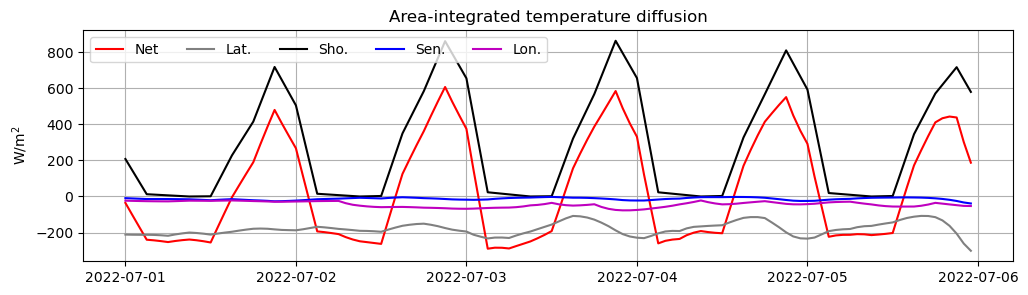

In [8]:
fig, ax = plt.subplots(1,1, figsize = (12,3))

ax.plot(ql.ocean_time, qnet, label = 'Net', lw = 1.5, c = 'r')
ax.plot(ql.ocean_time, ql, label = 'Lat.', lw = 1.5, c = 'gray')
ax.plot(ql.ocean_time, qsw, label = 'Sho.', lw = 1.5, c = 'k')
ax.plot(ql.ocean_time, qsen, label = 'Sen.', lw = 1.5, c = 'b')
ax.plot(ql.ocean_time, qlw, label = 'Lon.', lw = 1.5, c = 'm')

ax.legend(ncol = 5, loc = 'upper left')
ax.grid()
ax.set_title('Area-integrated temperature diffusion')
ax.set_ylabel('W/m$^2$')

# Combine them all to one plot, then look at effective heat flux budget 

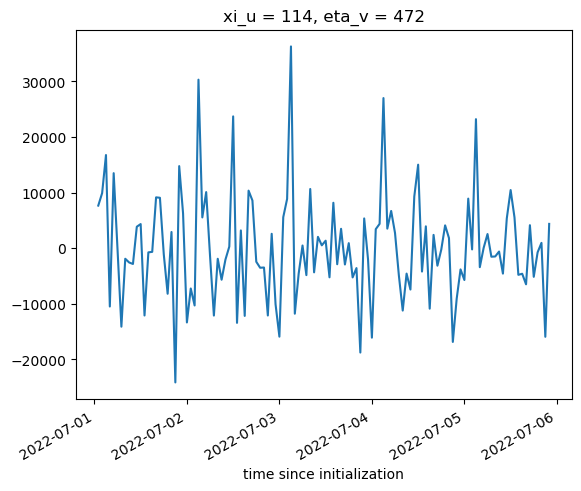

In [9]:
res = dTdt+tadv[1:-1]-vdiff[1:-1]
res.plot()

Text(0, 0.5, 'W/$m^2$')

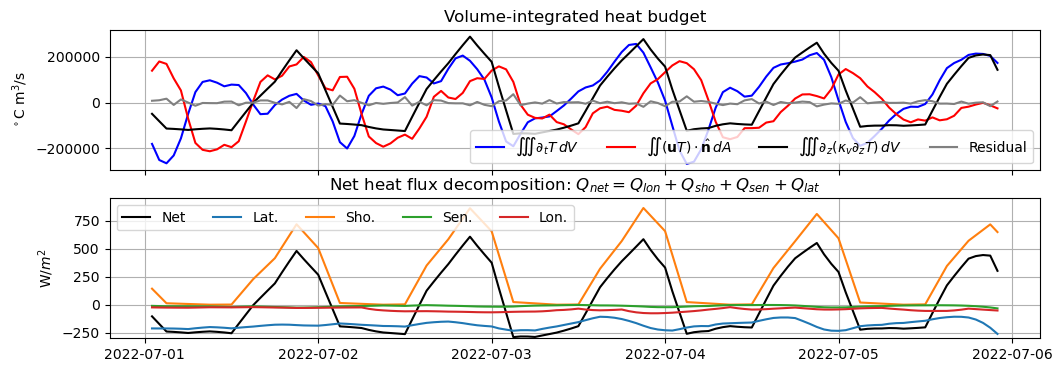

In [10]:
ds_dia = xr.open_dataset('heat_budget_june_10_16_2010.nc')

fig, ax = plt.subplots(2,1, figsize = (12,4), sharey=False)

ax[0].plot(tadv.ocean_time[1:-1], dTdt, label = r'$\iiint \partial_t T \, dV$', lw = 1.5, c = 'b')
ax[0].plot(tadv.ocean_time[1:-1], tadv[1:-1], label = r'$\iint (\mathbf{u}T) \cdot \hat{\mathbf{n}} \, dA$', lw = 1.5, c = 'r')
ax[0].plot(tadv.ocean_time[1:-1], vdiff[1:-1], label = r'$\iiint \partial_z \left(\kappa_v \partial_z T \right) \, dV$', lw = 1.5, c = 'k')
ax[0].plot(tadv.ocean_time[1:-1], res, label = 'Residual', lw = 1.5, c = 'gray')
ax[0].set_xticklabels('')
ax[0].set_title('Volume-integrated heat budget')

ax[1].plot(ql.ocean_time[1:-1], qnet[1:-1], label = 'Net', c = 'k', lw = 1.5)
ax[1].plot(ql.ocean_time[1:-1], ql[1:-1], label = 'Lat.', lw = 1.5)
ax[1].plot(ql.ocean_time[1:-1], qsw[1:-1], label = 'Sho.', lw = 1.5)
ax[1].plot(ql.ocean_time[1:-1], qsen[1:-1], label = 'Sen.', lw = 1.5)
ax[1].plot(ql.ocean_time[1:-1], qlw[1:-1], label = 'Lon.', lw = 1.5)
ax[1].set_ylim(-300,950)
ax[1].set_title('Net heat flux decomposition: $Q_{net} = Q_{lon}+Q_{sho}+Q_{sen}+Q_{lat}$')

for i in range(2):
    ax[i].grid(which='both')
    ax[i].legend(loc='best', ncol = 5)
ax[0].set_ylabel(r'$^\circ$C m$^3$/s')
ax[1].set_ylabel(r'W/$m^2$')

## Now compute Ekman buoyancy flux $EBF$ following Thomas et al. (2005) JPO and Shang et al. (2023) JGR: Oceans
### $Q_{EBF} = \left(\mathbf{\tau} \times \frac{\hat{k}}{\rho_0 f} \right) \cdot \nabla_H b = \frac{\tau_y \partial_x b}{\rho_0 f}+\frac{\tau_x \partial_y b}{\rho_0 f}$. 
where
> - $\mathbf{\tau}$ is the wind stress vector with components $\tau_x$ and $\tau_y$ [Pa | N/m$^2$],
> > - ```sustr``` and ```svstr``` in ROMS syntax
> - $b$ is the buoyancy [m/s$^2$]
> - $f$ is the coriolis parameter [1/s]
> - $\rho_0$ is the background density [kg/m$^3$]

When $Q_{EBF}<0$, winds tend to destabilize a front because winds tend to blow dense water on top of light water. The PV layer stratification is reduced such that the this is called down-front winds, so when  $Q_{net}+Q_{EBF}<0$ such that atmospheric forcing injectives negative Ertel PV into the ocean. 

In [21]:
rho = xroms.potential_density(ds.sel(ocean_time = tslice).temp,
                              ds.sel(ocean_time = tslice).salt,
                              z=0)
b = xroms.buoyancy(rho, rho0 = 1025)
# b = b.load()
taux = grid.interp(ds.sustr,'X', boundary = 'extend').sel(ocean_time = tslice).isel(eta_rho = etaslice, xi_rho = xislice)
tauy = grid.interp(ds.svstr,'Y', boundary = 'extend').sel(ocean_time = tslice).isel(eta_rho = etaslice, xi_rho = xislice)

dbdx = grid.derivative(b, 'X', boundary = 'exend')
dbdy = grid.derivative(b, 'Y', boundary = 'exend')

dbdx_rho = grid.interp(dbdx, 'X', boundary = 'extend')
dbdy_rho = grid.interp(dbdy, 'Y', boundary = 'extend')

dbdx_rho = dbdx_rho.isel(eta_rho = etaslice, xi_rho = xislice, s_rho = -1)
dbdy_rho = dbdy_rho.isel(eta_rho = etaslice, xi_rho = xislice, s_rho = -1)

# ebf = (()/())+(()/())